# Binary Classification using Tensorflow

We are going to do similar to the Regression Tensorflow workbook, but this time we are going to work at a classification problem

Back to the titanic.csv file we used before

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Read and clean data

We'll need to read in the data and do the following
- Remove any rows without Embarked filled in
- Fill in any missing ages with a median value
- Pick the columns we are going to build our model with
- Encode some columns - convert from text to numbers
  - Sex using label encoder
  - Embarked using Onehotencoder

In [2]:
df = pd.read_csv("titanic.csv")
df = df[df["Embarked"].notnull()]   #Remove any rows without Embarked filled in
df['Age'] = df['Age'].fillna(df['Age'].median())    #Fill in any missing ages with a median value

#Pick the columns we are going to build our model with
y = df["Survived"]
X = df[["Pclass","Age","Sex","SibSp","Parch","Fare","Embarked"]]

Convert sex to numeric values using label encoder from preprocessing library

In [3]:
from sklearn import preprocessing
le_sex = preprocessing.LabelEncoder()
le_sex.fit(X['Sex'])
sex = le_sex.transform(X['Sex'])
X = X.drop(['Sex'], axis = 1)
X['Sex'] = sex

Convert Embarked to numeric values using OneHotEncoder from preprocessing library. There's probably a better way of doing this but this'll work

In [4]:
le_embark = preprocessing.OneHotEncoder(sparse_output=False)
le_embark.fit(X["Embarked"].values.reshape(-1,1))
embarked = le_embark.transform(X["Embarked"].values.reshape(-1,1))
X = X.drop(["Embarked"], axis = 1)
X["EmbarkC"] = embarked[:,0]
X["EmbarkQ"] = embarked[:,1]
X["EmbarkS"] = embarked[:,2]
X

,Pclass,Age,SibSp,Parch,Fare,Sex,EmbarkC,EmbarkQ,EmbarkS
0,3,22.0,1,0,7.2500,1,0.0,0.0,1.0
1,1,38.0,1,0,71.2833,0,1.0,0.0,0.0
2,3,26.0,0,0,7.9250,0,0.0,0.0,1.0
3,1,35.0,1,0,53.1000,0,0.0,0.0,1.0
4,3,35.0,0,0,8.0500,1,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
886,2,27.0,0,0,13.0000,1,0.0,0.0,1.0
887,1,19.0,0,0,30.0000,0,0.0,0.0,1.0
888,3,28.0,1,2,23.4500,0,0.0,0.0,1.0
889,1,26.0,0,0,30.0000,1,1.0,0.0,0.0


### Machine Learning 
Then we can start doing our Machine Learning process
- Train_test_split
- Normalise the data
- Write the base models
- Compile
- Fit
- Evaluate
Usual Train Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1138, train_size=0.8)

Normalisation like was done on the Regression workbook

In [6]:
from tensorflow.keras.layers.experimental import preprocessing

normalizer = preprocessing.Normalization()
normalizer.adapt(X_train.values)
print('Normalized:', normalizer(X_train.values).numpy())

Normalized: [[-1.595036    0.14717188 -0.4633815  ... -0.4819084  -0.3198837
   0.6256113 ]
 [ 0.8076563  -1.5724919  -0.4633815  ... -0.4819084  -0.3198837
   0.6256113 ]
 [ 0.8076563  -0.08732772 -0.4633815  ...  2.0750833  -0.3198837
  -1.5984366 ]
 ...
 [-1.595036   -0.08732772 -0.4633815  ... -0.4819084  -0.3198837
   0.6256113 ]
 [ 0.8076563  -0.71266    -0.4633815  ... -0.4819084  -0.3198837
   0.6256113 ]
 [-0.3936899  -2.1978242   1.3031831  ... -0.4819084  -0.3198837
   0.6256113 ]]


## Model Number 1 - Logistic Regression

We are just going to do a regular Logistic Regression model to start with

This just requires one output layer with one unit in it so it is the same as
$$\log\left(\frac{p}{1-p}\right) = w^Tx + b $$

This should be similar to using sklearn LogisticRegression()

We put the normalizer in as a layer

In [7]:
model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 9)                 19        
 on)                                                             
                                                                 
 dense (Dense)               (None, 1)                 10        
                                                                 
Total params: 29 (120.00 Byte)
Trainable params: 10 (40.00 Byte)
Non-trainable params: 19 (80.00 Byte)
_________________________________________________________________


Trainable params is 10, we have 9 features (so 9 weights) and the bias b to be learnt as well

Our loss is going to be https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy as it is a binary problem

Read the manual even though the default is from_logits=False, they say Recommended Usage: (set from_logits=True (meaning output data is unscaled)). This depends on our output layer, if you look above I did not put any activation on the output layer, so the outputs will be logits i.e. from -infinity to +infinity

If I put above tf.keras.layers.Dense(1, activation='sigmoid') then from_logits=False is needed, but it is not recommended according to the manual

In [8]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    metrics='accuracy',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

model.fit(X_train, y_train, epochs=100)

Epoch 1/100
23/23 [==============================] - 1s 2ms/step - loss: 0.5617 - accuracy: 0.7440
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4449 - accuracy: 0.8003
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4407 - accuracy: 0.8101
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4416 - accuracy: 0.8073
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4431 - accuracy: 0.7975
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4475 - accuracy: 0.8059
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4435 - accuracy: 0.8143
Epoch 8/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4429 - accuracy: 0.8129
Epoch 9/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4531 - accuracy: 0.8045
Epoch 10/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4464 - accuracy: 0.8087
Epoch 11/

Loss keeps decreasing, haven't use a validation set though. Could've done a different number of epochs

Be careful if you run .fit again. It continues on from where you left off, not starting from epoch 1 again

In [9]:
logRegEval = model.evaluate(X_test, y_test)
print("Logistic Regression Loss: ", round(logRegEval[0],4), "Accuracy: ", round(logRegEval[1],4))

6/6 [==============================] - 0s 2ms/step - loss: 0.5082 - accuracy: 0.7809
Logistic Regression Loss:  0.5082 Accuracy:  0.7809


## Model Number 2 - Neural Network

Now we are going to build a Neural Network

4 layers, 100 units in each hidden layer with relu as the activation function (you can try different structures if you want but for now I'm just demonstrating how Tensorflow works as well as some other things we can try)

In [10]:
model_tf = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
model_tf.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 9)                 19        
 on)                                                             
                                                                 
 dense_1 (Dense)             (None, 100)               1000      
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 21320 (83.29 KB)
Trainable params: 21301 (83.21 KB)
Non-trainable params: 19 (80.00 Byte)
________________

21301 trainable params, a lot more than the previous 10! Let's look at each layer

Input has 9 features Hidden Layer 1 has 100 units. Therefore the weight matrix is going to have 100 rows and 9 columns to match
$$ Wx + b $$

That gives us 900 paramaters for the weights. Then we have 100 biases - giving the total of 1000 parameters to go from input layer to hidden layer 1

Now from hidden layer 1 to hidden layer 2. 100 features, 100 units, gives us a 100x100 matrix so 10000 parameters, add in the 100 biases and we get the 10100

Let's compile and fit

In [12]:
model_tf.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    metrics='accuracy',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

model_tf.fit(X_train, y_train, epochs=100)

Epoch 1/100
23/23 [==============================] - 1s 3ms/step - loss: 0.5216 - accuracy: 0.7553
Epoch 2/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4257 - accuracy: 0.8242
Epoch 3/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3981 - accuracy: 0.8354
Epoch 4/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4055 - accuracy: 0.8354
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3919 - accuracy: 0.8383
Epoch 6/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3973 - accuracy: 0.8284
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3754 - accuracy: 0.8383
Epoch 8/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3831 - accuracy: 0.8340
Epoch 9/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3669 - accuracy: 0.8467
Epoch 10/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3691 - accuracy: 0.8467
Epoch 11/

Again Loss keeps decreasing, haven't use a validation set though. Could've done a different number of epochs

In [13]:
print("Logistic Regression Loss: ", round(logRegEval[0],4), "Accuracy: ", round(logRegEval[1],4))

Logistic Regression Loss:  0.5082 Accuracy:  0.7809


In [14]:
annEval = model_tf.evaluate(X_test, y_test)
print("ANN Loss: ", round(annEval[0],4), "Accuracy: ", round(annEval[1],4))

6/6 [==============================] - 0s 3ms/step - loss: 1.3069 - accuracy: 0.7921
ANN Loss:  1.3069 Accuracy:  0.7921


These are potentially overfit, we should have done some validation to check over things

While the accuracy for the test data is better, the loss is actually worse!

## Using Validation
### Logistic Regression with Validation

Let's add in validation. kFold Cross Validation would be nice but that's more difficult to do with tensorflow and requires writing our own functions so let's just take the last 20% as a validation set. Since we used train_test_split already, the data is already shuffled so it should be ok

In [15]:
model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 9)                 19        
 on)                                                             
                                                                 
 dense_5 (Dense)             (None, 1)                 10        
                                                                 
Total params: 29 (120.00 Byte)
Trainable params: 10 (40.00 Byte)
Non-trainable params: 19 (80.00 Byte)
_________________________________________________________________


In [16]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    metrics='accuracy',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
18/18 [==============================] - 1s 14ms/step - loss: 0.5213 - accuracy: 0.7465 - val_loss: 0.4013 - val_accuracy: 0.8252
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 0.4658 - accuracy: 0.8134 - val_loss: 0.3794 - val_accuracy: 0.8462
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 0.4573 - accuracy: 0.8134 - val_loss: 0.3982 - val_accuracy: 0.8322
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 0.4576 - accuracy: 0.7993 - val_loss: 0.3914 - val_accuracy: 0.8462
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 0.4523 - accuracy: 0.8063 - val_loss: 0.3878 - val_accuracy: 0.8392
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 0.4564 - accuracy: 0.7870 - val_loss: 0.3917 - val_accuracy: 0.8392
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 0.4558 - accuracy: 0.8099 - val_loss: 0.3878 - val_accuracy: 0.8322
Epoch 8/100


Same function that was in the previous notebook

In [17]:
def plot_loss(history, which='loss'):
    plt.plot(history.history[which], label='train')
    try:
        plt.plot(history.history['val_'+which], label='validation')
    except:
        None
    plt.xlabel('Epoch')
    plt.ylabel(which)
    plt.legend()
    plt.grid(True)

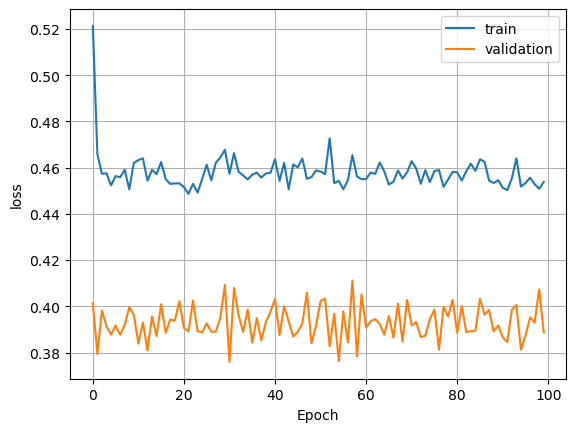

In [18]:
plot_loss(history)

In [19]:
logRegValidationEval = model.evaluate(X_test, y_test)
print("Logistic Regression with Validation Loss: ", round(logRegValidationEval[0],4), "Accuracy: ", round(logRegValidationEval[1],4))

6/6 [==============================] - 0s 2ms/step - loss: 0.5020 - accuracy: 0.7697
Logistic Regression with Validation Loss:  0.502 Accuracy:  0.7697


Seems about the same performance on the test set. Your numbers will vary due to SGD

Now ANN

### ANN with Validation

In [20]:
model_tf = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(1)
])

model_tf.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    metrics='accuracy',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

history = model_tf.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
18/18 [==============================] - 2s 22ms/step - loss: 0.5251 - accuracy: 0.7711 - val_loss: 0.4156 - val_accuracy: 0.8252
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.4454 - accuracy: 0.8046 - val_loss: 0.3935 - val_accuracy: 0.8601
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 0.4031 - accuracy: 0.8292 - val_loss: 0.4785 - val_accuracy: 0.8392
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.3978 - accuracy: 0.8257 - val_loss: 0.4330 - val_accuracy: 0.8462
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 0.3812 - accuracy: 0.8363 - val_loss: 0.4874 - val_accuracy: 0.8462
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.3771 - accuracy: 0.8345 - val_loss: 0.5395 - val_accuracy: 0.8182
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 0.3937 - accuracy: 0.8187 - val_loss: 0.5088 - val_accuracy: 0.8392
Epoch 8/100


Let's plot the loss graph

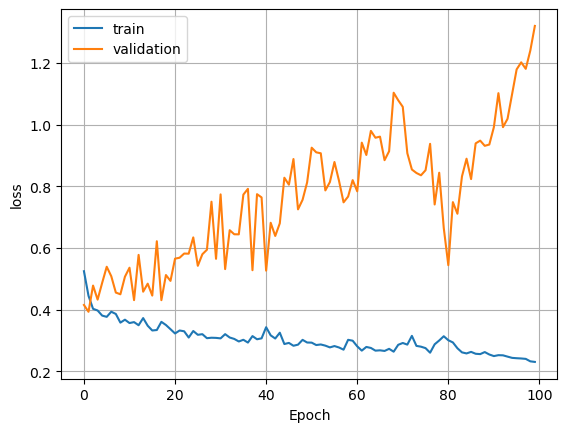

In [21]:
plot_loss(history)

Validation loss is a bit all over the place. This suggests overfitting to me

Neural Networks are not always better....even though the training loss and accuracy was better with the NN

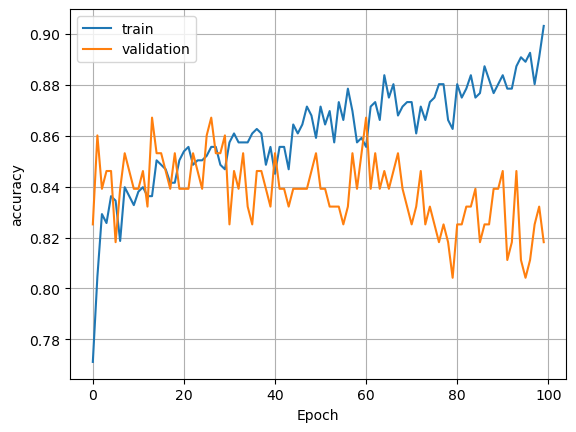

In [22]:
plot_loss(history, 'accuracy')

In [23]:
print("Logistic Regression with Validation Loss: ", round(logRegValidationEval[0],4), "Accuracy: ", round(logRegValidationEval[1],4))

Logistic Regression with Validation Loss:  0.502 Accuracy:  0.7697


In [24]:
annValidationEval = model_tf.evaluate(X_test, y_test)
print("ANN with Validation Loss: ", round(annValidationEval[0],4), "Accuracy: ", round(annValidationEval[1],4))

6/6 [==============================] - 0s 5ms/step - loss: 1.8063 - accuracy: 0.7865
ANN with Validation Loss:  1.8063 Accuracy:  0.7865


The NN did do better with the test set in terms of accuracy but loss quite a bit worse

## ANN with Regularisation

Ok, let's try smoothing some of that out with adding l2 regularisation to the layers

In [25]:
#Defining model with L2 regularisation
model_tf = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(100,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01), bias_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(100,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01), bias_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(100,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01), bias_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1)
])

model_tf.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    metrics='accuracy',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

history = model_tf.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
18/18 [==============================] - 3s 34ms/step - loss: 1.3739 - accuracy: 0.7412 - val_loss: 0.6113 - val_accuracy: 0.8531
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.6040 - accuracy: 0.8046 - val_loss: 0.5108 - val_accuracy: 0.8531
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.5327 - accuracy: 0.8239 - val_loss: 0.4925 - val_accuracy: 0.8671
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.5057 - accuracy: 0.8134 - val_loss: 0.4601 - val_accuracy: 0.8531
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.5102 - accuracy: 0.8151 - val_loss: 0.4508 - val_accuracy: 0.8531
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.5085 - accuracy: 0.8134 - val_loss: 0.4727 - val_accuracy: 0.8462
Epoch 7/100
18/18 [==============================] - 0s 12ms/step - loss: 0.5050 - accuracy: 0.8134 - val_loss: 0.4562 - val_accuracy: 0.8322
Epoch 8/100

val_loss: 0.4876 - val_accuracy: 0.8462 , so better than the last NN we build

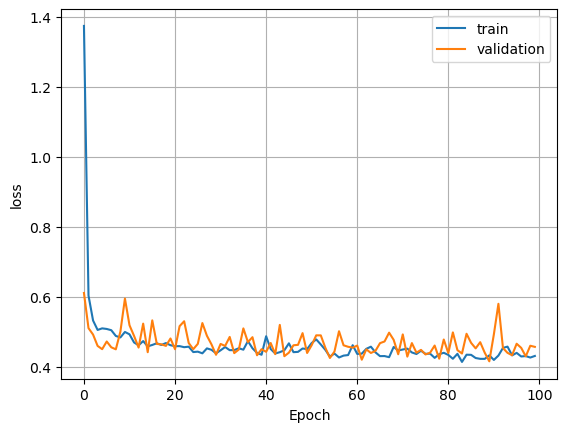

In [26]:
plot_loss(history)

That graph looks a lot better with some regularisation

In [27]:
model_tf.evaluate(X_test, y_test)
annValidationRegularisationEval = model_tf.evaluate(X_test, y_test)
print("ANN with Regularisation & Validation Loss: ", round(annValidationRegularisationEval[0],4), "Accuracy: ", round(annValidationRegularisationEval[1],4))

6/6 [==============================] - 0s 3ms/step - loss: 0.5400 - accuracy: 0.8146
ANN with Regularisation & Validation Loss:  0.54 Accuracy:  0.8146


In [28]:
print("Logistic Regression Loss: ", round(logRegEval[0],4), "Accuracy: ", round(logRegEval[1],4))
print("ANN Loss: ", round(annEval[0],4), "Accuracy: ", round(annEval[1],4))
print("Logistic Regression with Validation Loss: ", round(logRegValidationEval[0],4), "Accuracy: ", round(logRegValidationEval[1],4))
print("ANN with Validation Loss: ", round(annValidationEval[0],4), "Accuracy: ", round(annValidationEval[1],4))
print("ANN with Regularisation & Validation Loss: ", round(annValidationRegularisationEval[0],4), "Accuracy: ", round(annValidationRegularisationEval[1],4))

Logistic Regression Loss:  0.5082 Accuracy:  0.7809
ANN Loss:  1.3069 Accuracy:  0.7921
Logistic Regression with Validation Loss:  0.502 Accuracy:  0.7697
ANN with Validation Loss:  1.8063 Accuracy:  0.7865
ANN with Regularisation & Validation Loss:  0.54 Accuracy:  0.8146


Interesting to see that ANN doesn't do the best in terms of loss but does well in accuracy performace - shows that optimising for loss and accuracy are not the same thing. Also shows that a simpler model can sometimes be better choice